In [113]:
#pip install geopandas

In [114]:
#pip install folium matplotlib mapclassify

In [115]:
from obspy import read
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import seaborn as sns

In [116]:
syn_dir = "sw4_test_output" # synthetic 
obs_dir = "obs_test_output" # observation 

In [117]:
station = "BRK"
station2 = "BKS"

network = "BK"
sensor = "HN"
component = "e"

In [118]:
st_syn = read(syn_dir+"/"+network+"."+station+"."+sensor+"."+component)
st_obs = read(obs_dir+"/"+network+"."+station2+"."+sensor+"."+component)

### Plot of observed and simulation on the same scale
The simulation has way fewer data points and has a much smaller scale than the observed data. I think they have the same keywords associated with them though.

In [119]:
obs_times = st_obs[0].times()
obs_times

array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 3.8997e+02, 3.8998e+02,
       3.8999e+02])

In [120]:
backwards_obs = np.flip(st_obs[0].data)
backwards_syn = np.flip(st_syn[0].data)

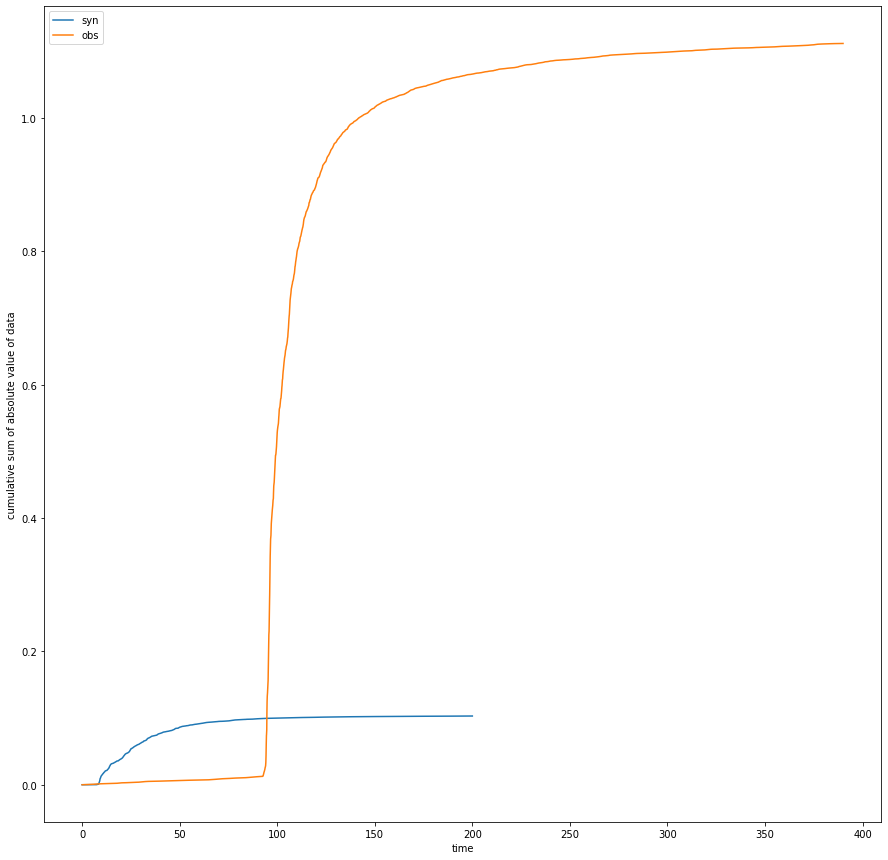

In [121]:
fig, ax = plt.subplots(figsize=(15,15))
plt.plot(st_syn[0].times(), np.cumsum(np.abs(st_syn[0].data)), label = 'syn')
plt.plot(st_obs[0].times(), np.cumsum(np.abs(st_obs[0].data)), label = 'obs')
plt.xlabel("time")
plt.ylabel("cumulative sum of absolute value of data")
plt.legend();

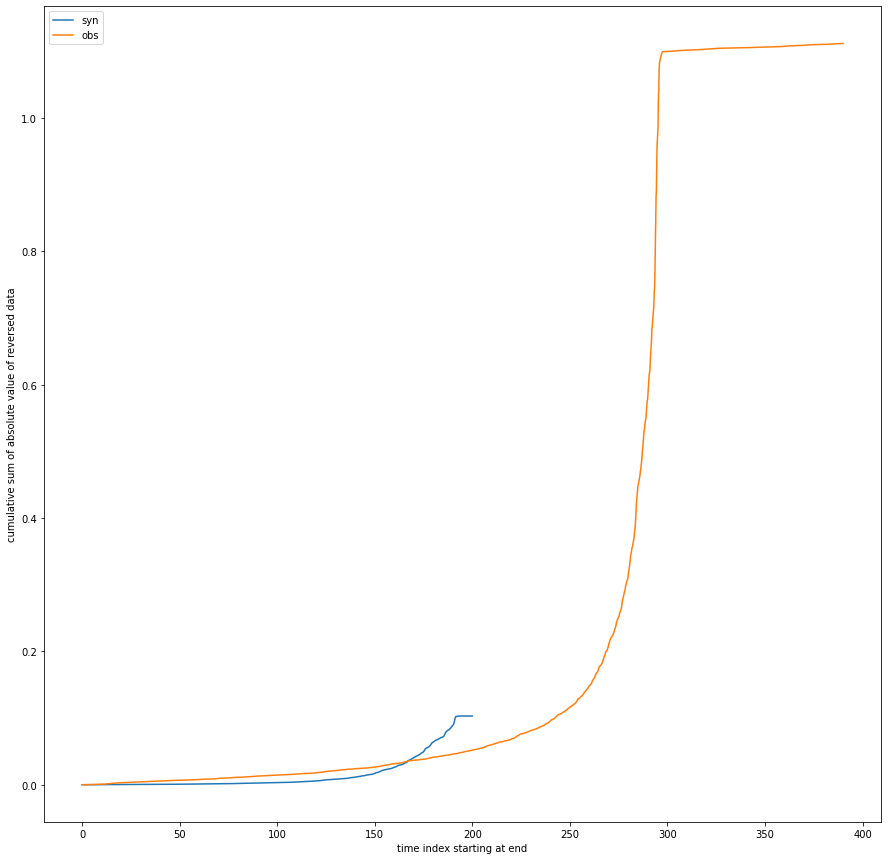

In [122]:
fig, ax = plt.subplots(figsize=(15,15))
plt.plot(st_syn[0].times(), np.cumsum(np.abs(backwards_syn)), label = 'syn')
plt.plot(st_obs[0].times(), np.cumsum(np.abs(backwards_obs)), label = 'obs')
plt.xlabel("time index starting at end")
plt.ylabel("cumulative sum of absolute value of reversed data")
plt.legend();

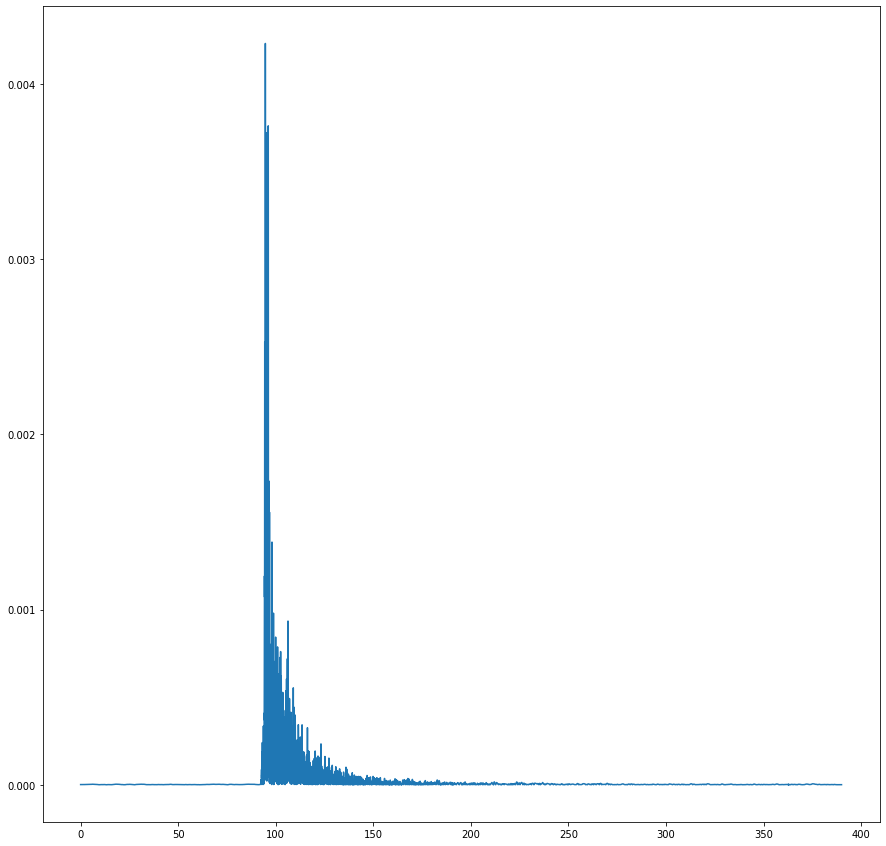

In [123]:
fig, ax = plt.subplots(figsize=(15,15))
plt.plot(st_obs[0].times()[1:], np.diff(np.cumsum(np.abs(st_obs[0].data))));

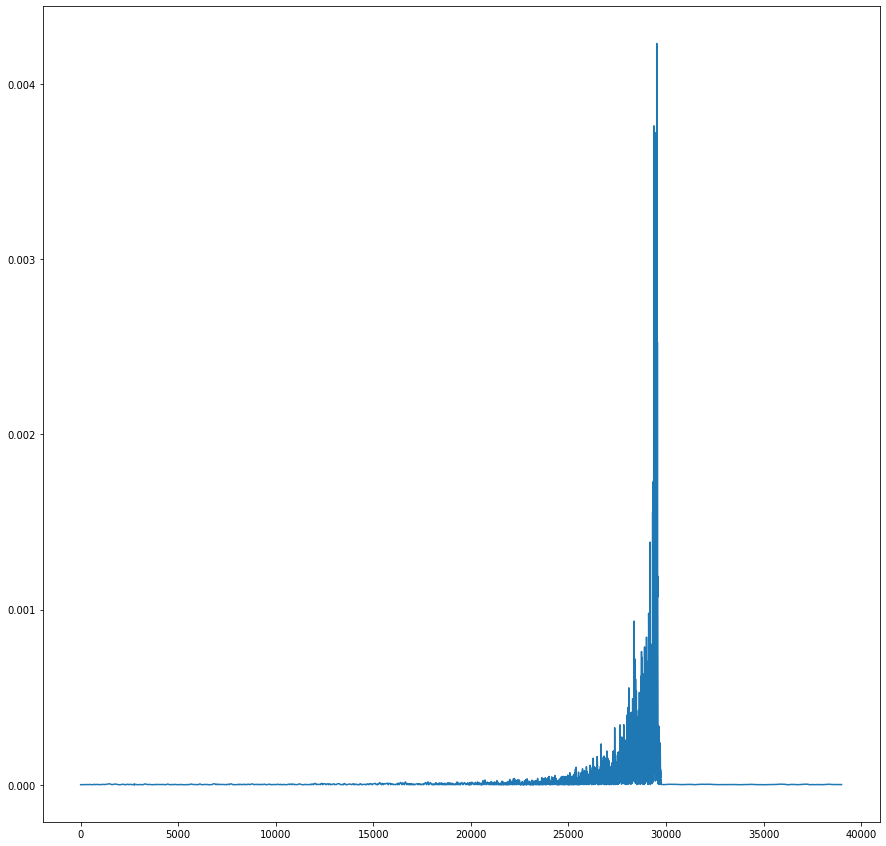

In [124]:
fig, ax = plt.subplots(figsize=(15,15))
plt.plot(np.diff(np.cumsum(np.abs(backwards_obs))));

In [125]:
end_threshold = (np.cumsum(np.abs(backwards_obs)))[25000]
end_threshold

0.11636013

I chose the end threshold as when the cumulative sum of absolute values of backwards data reaches whatever it is at the 25000th time index of this particular data. Visually, looking at the graph of backwards data, it appears that the differences pick up about 25000 indices from the end.

In [126]:
start_obs = np.argmax(np.diff(np.cumsum(np.abs(backwards_obs))))
start_obs

29529

I chose the start as simply the index of the largest difference, (on the backwards data to maintain consistency with how I chose the end). 

end index is the first value at which the cumulative sum of the backwards data is greater than or equal to the end threshold, which I've set to be the cumulative sum at index 26000, which I chose from the graph. I chose the backwards data because if we look at the backwards data graph, the end of the earthquake is approximately when the backwards data starts to grow.

In [127]:
end_idx = np.argmax(((np.cumsum(np.abs(backwards_obs))) >= end_threshold).astype(int))
end_idx

25000

To calculate the time difference, we need to access the array of times observations were taken. Since we used the backwards data to get the indices which we determined start and end to be, we need to flip time too. After this, end - start determines how long the earthquake is. 

In [128]:
flipped_time = np.flip(st_obs[0].times())
flipped_time[end_idx] - flipped_time[start_obs]

45.290000000000006

Unfortunately, since this approach involved manually looking at the graphs to find the end of the earthquake, it will not apply well to the other earthquakes. We at least can find the beginning with the np.argmax(differences) approach but the end of the earthquake remains in question. 

One issue with trying to analyze the differences was the fluctuations by data points. By fluctuations, I mean that though the overall graph of differences shows a trend, on a smaller granularity level, some differences are small and close to 0, and others are a bit larger, but since there are ~40,000 data points, the nonzero values really overshadow the small values in between. The reality of the graph is spiky. 

Next, I'm going to explore smoothing methods to see if the differences are more clear.

https://stackoverflow.com/questions/5283649/plot-smooth-line-with-pyplot

what is List-> ...

recommended by Google search ..

https://danielmuellerkomorowska.com/2020/06/02/smoothing-data-by-rolling-average-with-numpy/

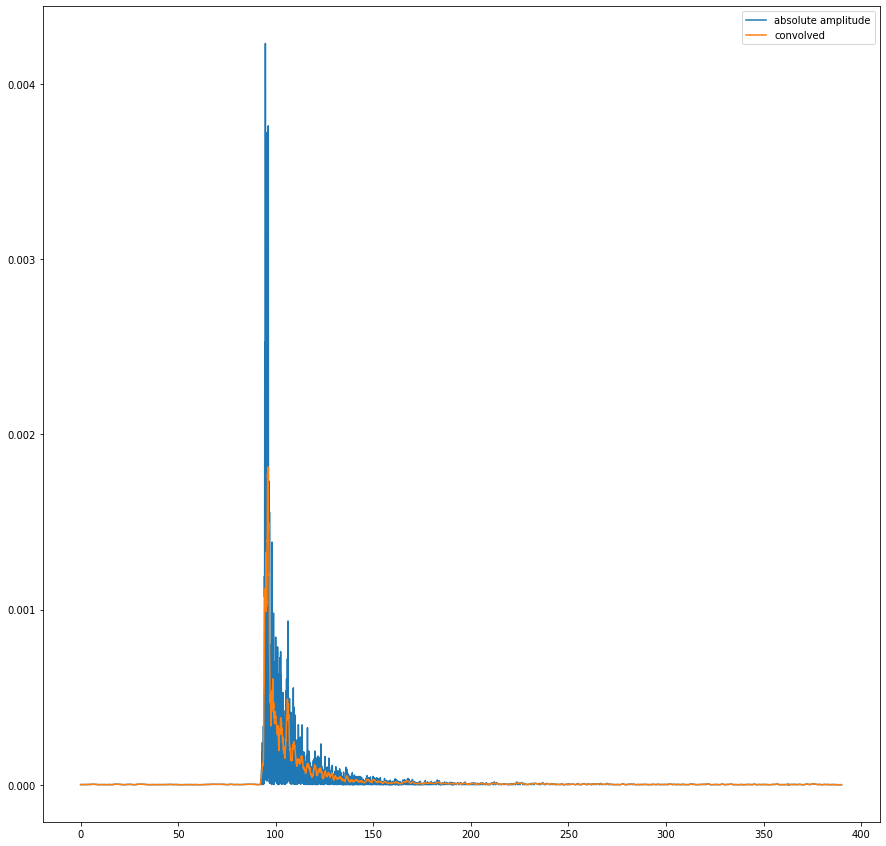

In [129]:
fig, ax = plt.subplots(figsize=(15,15))

kernel_size = 100
kernel = np.ones(kernel_size) / kernel_size
data_convolved = np.convolve(abs(st_obs[0].data), kernel, mode='same')

plt.plot(st_obs[0].times(), abs(st_obs[0].data), label = 'absolute amplitude');
plt.plot(st_obs[0].times(), data_convolved, label = 'convolved');
plt.legend();

Now what if I "convolve" the differenced data? 


In [130]:
kernel_size2 = 100
#bigger size = smoother
kernel2 = np.ones(kernel_size2) / kernel_size2
diffdata_convolved = np.convolve(np.diff(np.cumsum(abs(st_obs[0].data))), kernel2, mode='same')

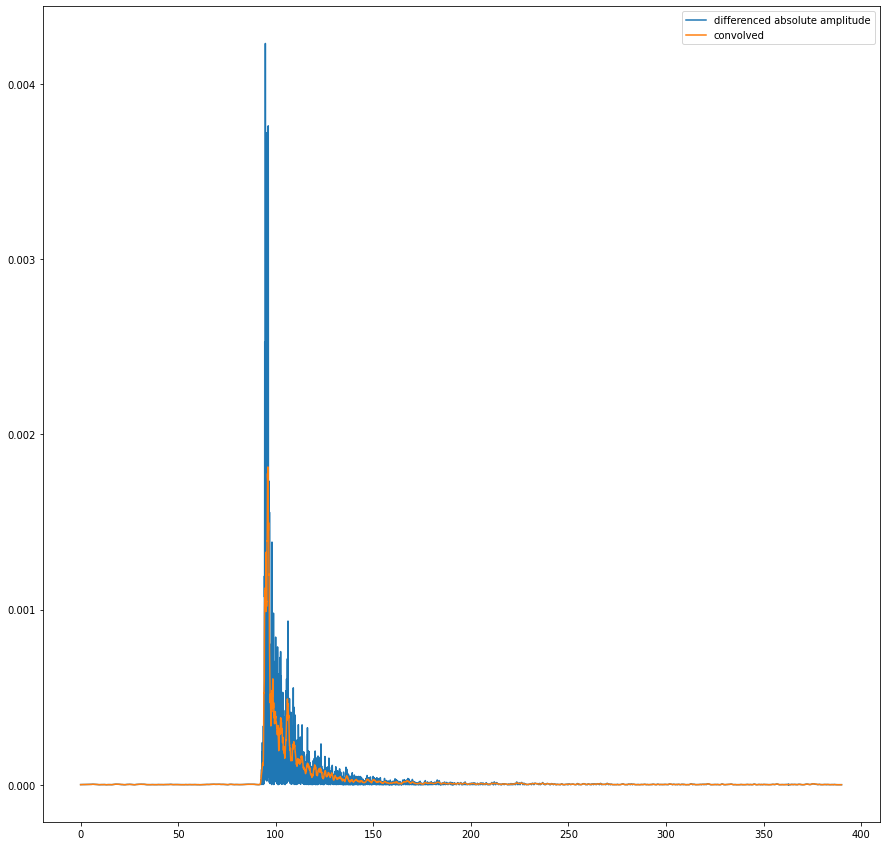

In [131]:
fig, ax = plt.subplots(figsize=(15,15))

plt.plot(st_obs[0].times()[1:], np.diff(np.cumsum(abs(st_obs[0].data))), label = 'differenced absolute amplitude');
plt.plot(st_obs[0].times()[1:], diffdata_convolved, label = 'convolved');
plt.legend();

Ok.. this graph looks pretty much exactly the same even though I thought I was doing something different. But in conclusion, this a method of making the graph look smoother. Finding the end? taking the difference again?

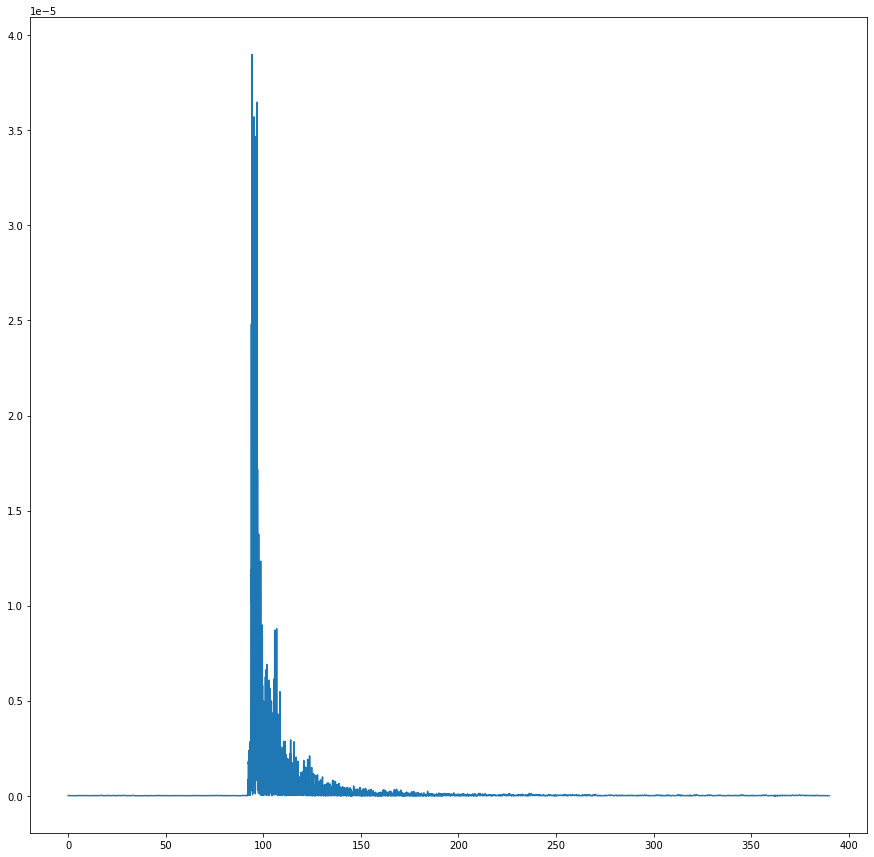

In [132]:
smooth_second_diff = np.abs(np.diff(diffdata_convolved))
fig, ax = plt.subplots(figsize=(15,15))
plt.plot(st_obs[0].times()[2:], smooth_second_diff)


Took the difference again, and then the absolute value, and now it just looks messy again.

Normalized absolute:

In [133]:
obs_normalized = abs(st_obs[0].data / st_obs[0].data[len(st_obs[0].data) - 1])
percentile_90 = np.percentile(obs_normalized, 90)
percentile_90

89.70821914672847

the 90th percentile of normalized values is 25.68. How to get the time where this occurred? Can use argmax again.

In [134]:
np.argmax(obs_normalized == percentile_90)

0

the 90th percentile is an in between value, so no value is exactly equal. HHowever, if we flip the data again, and use >=, we can find the latest point at which the ratio was >= than this percentile.

In [135]:
potential_endpt = np.argmax(np.flip(obs_normalized) >= percentile_90)
potential_endpt

22179

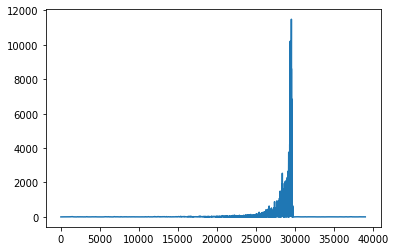

In [136]:
plt.plot(np.flip(obs_normalized));

Since the data is flipped, then to get the true timestamp, subtract this value from number of timestamps, which is 40,000.


In [137]:
potential_endpt = len(obs_normalized) - potential_endpt
potential_endpt

16821

In [138]:
potential_start = np.argmax(np.diff(np.cumsum(abs(st_obs[0].data))))
potential_start

9468

In [139]:
st_obs[0].times()[potential_endpt] - st_obs[0].times()[potential_start]

73.53

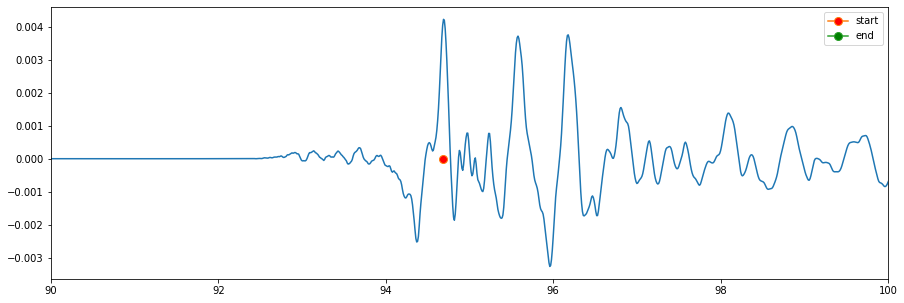

In [140]:
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(st_obs[0].times(), st_obs[0].data);
plt.plot(st_obs[0].times()[potential_start], 0, marker="o", markersize=8, markerfacecolor="red",label='start');
plt.plot(st_obs[0].times()[potential_endpt], 0, marker="o", markersize=8, markerfacecolor="green", label='end');
plt.xlim(90, 100);
plt.legend();

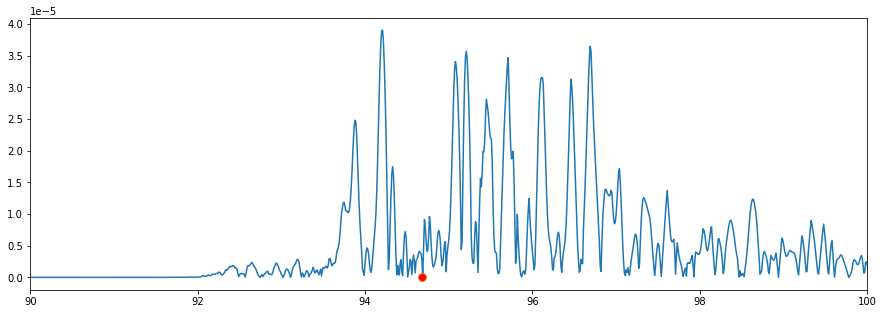

In [141]:
smooth_second_diff = np.abs(np.diff(diffdata_convolved))
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(st_obs[0].times()[2:], smooth_second_diff)
plt.plot(st_obs[0].times()[potential_start], 0, marker="o", markersize=8, markerfacecolor="red",label='start');
plt.xlim(90, 100);

In [142]:
def plot_duration(data, times, desired_percentile = 90):
    #normalize by the smallest value?
    data_normalized = abs(data / min(data))
    nth_percentile = np.percentile(data_normalized, desired_percentile)
    #first place starting from the end where the normalized data exceeds the percentile
    #then to get actual point in time, subtract from total data points
    potential_endpt = len(data_normalized) - np.argmax(np.flip(data_normalized) >=nth_percentile)
    #place with ther largest difference 
    potential_start = np.argmax(np.diff(np.cumsum(abs(data))))
    duration = times[potential_endpt] - times[potential_start]
    fig, ax = plt.subplots(figsize=(15,15))
    plt.plot(times, data);
    plt.plot(times[potential_start], 0, marker="o", markersize=8, markerfacecolor="red",label='start');
    plt.plot(times[potential_endpt], 0, marker="o", markersize=8, markerfacecolor="green", label='end');
    plt.legend();
    return None
    
    

In [143]:
def duration_calc(data, times, desired_percentile = 90):
    #normalize by the smallest value?
    data_normalized = abs(data / min(data))
    nth_percentile = np.percentile(data_normalized, desired_percentile)
    #first place starting from the end where the normalized data exceeds the percentile
    #then to get actual point in time, subtract from total data points
    potential_endpt = len(data_normalized) - np.argmax(np.flip(data_normalized) >=nth_percentile) - 1
    #place with ther largest difference 
    potential_start = np.argmax(np.diff(np.cumsum(abs(data))))
    duration = times[potential_endpt] - times[potential_start]
    return duration

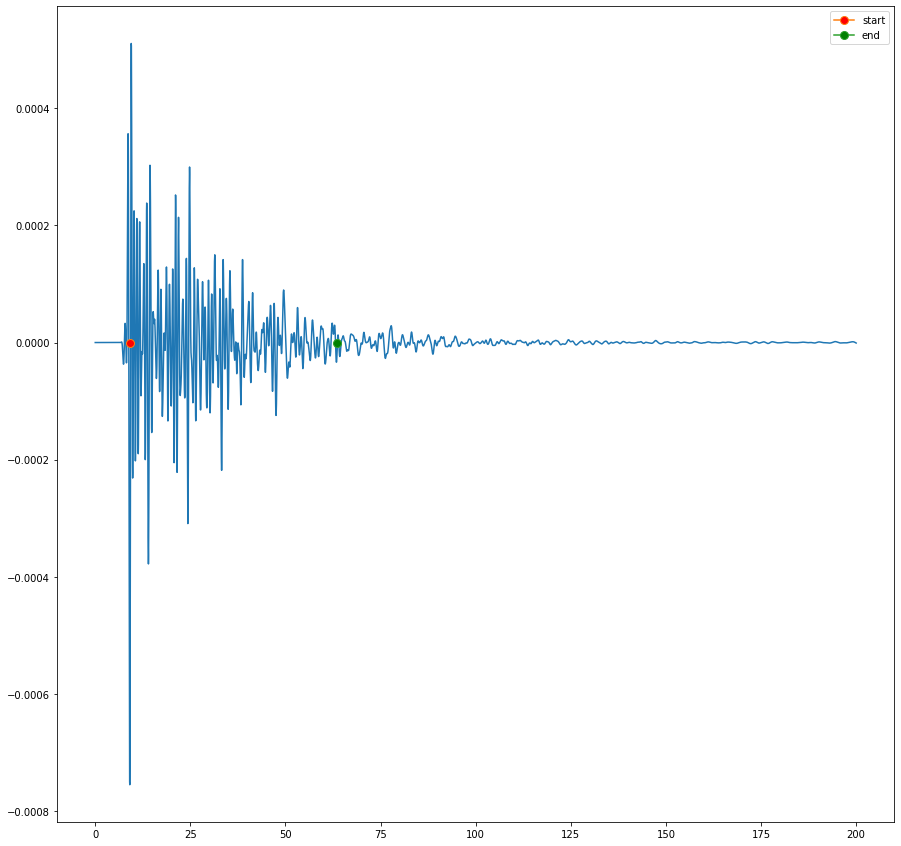

In [144]:
plot_duration(st_syn[0].data, st_syn[0].times(), 85)

In [145]:
print(st_syn)

1 Trace(s) in Stream:
.BK.BRK..EW | 2018-01-04T10:39:32.690000Z - 2018-01-04T10:42:52.690007Z | 26.5 Hz, 5309 samples


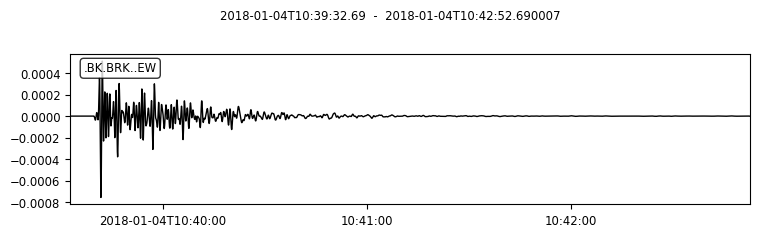

In [146]:
_plot = st_syn.plot()

In [147]:
st_syn[0].stats["sac"]["stlo"]

-122.26099

In [148]:
d = {'name': [ 'obs center'], 'lon': -122.257, 'lat': 37.855 }
df = pd.DataFrame(data=d)
df

,name,lon,lat
0,obs center,-122.257,37.855


In [149]:
crs = 'EPSG:4326'
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
geo_df = gpd.GeoDataFrame(df, 
                          crs = crs, 
                          geometry = geometry)
geo_df = geo_df.to_crs(epsg=4326)
geo_df

,name,lon,lat,geometry
0,obs center,-122.257,37.855,POINT (-122.25700 37.85500)


In [150]:
bay_shapefile = gpd.read_file('bayarea_county.shx')
bay_shapefile.crs = "EPSG:4326"
#fig, ax = plt.subplots(figsize=(10,10))
#bay_shapefile  = bay_shapefile[bay_shapefile.geom_type != 'Polygon']

#geo_df.plot(ax=bay_shapefile.plot(ax=ax, facecolor='Grey', edgecolor='k',alpha=1,linewidth=1,cmap="magma", aspect = 1), color='blue',  markersize=10);
#geo_df.crs

In [151]:
#fig, ax = plt.subplots(figsize=(10,10))
#geo_df.plot(ax=bay_shapefile.plot(figsize=(10, 10),aspect = 1))
#bay_shapefile.crs = "EPSG:4326"
#bay_shapefile.plot(ax=ax, facecolor='Grey', edgecolor='k',alpha=1,linewidth=1,cmap="magma", aspect = 1);

## make functionality to plot a larger variety of points

In [154]:
import os
#make sure to move weird files to a different place
#works specifically for the observed test output
def convert_obs_data():
    latitudes = []
    longitudes = []
    names = []
    max_amp = []
    duration = []
    for file in os.listdir('obs_test_output'): 
        if (len(file)<= 15):
            st_obs = read('obs_test_output'+'/'+file)
            longitudes.append(st_obs[0].stats["sac"]["stlo"])
            latitudes.append(st_obs[0].stats["sac"]["stla"])
            duration.append(duration_calc(st_obs[0].data, st_obs[0].times(), 90))
            names.append(file)
            max_amp.append(max(abs(st_obs[0].data)))
            
    data_dict = { 'name': names,'lon': longitudes, 'lat': latitudes, 'max_amp': max_amp, 'duration': duration}
    df = pd.DataFrame(data=data_dict)
    crs = 'EPSG:4326'
    geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
    geo_df = gpd.GeoDataFrame(df, 
                          crs = crs, 
                          geometry = geometry)
    
    return geo_df

In [155]:
observed_eqdata = convert_obs_data()
observed_eqdata

,name,lon,lat,max_amp,duration,geometry
0,NC.RWSVT.HN.2,-122.263023,37.944080,0.024850,20.490,POINT (-122.26302 37.94408)
1,NC.C049.HN.e,-122.278458,37.776600,0.012901,54.290,POINT (-122.27846 37.77660)
2,NC.JSA.HN.u,-122.420059,37.582249,0.003152,70.780,POINT (-122.42006 37.58225)
3,CE.68323.HN.e,-122.116997,38.033401,0.002420,20.445,POINT (-122.11700 38.03340)
4,NC.J004.HN.e,-122.036446,37.317459,0.003191,76.290,POINT (-122.03645 37.31746)
...,...,...,...,...,...,...
1057,NP.1778.HN.e,-121.979782,37.302494,0.004043,96.000,POINT (-121.97978 37.30249)
1058,BK.MHC.HN.u,-121.642570,37.341640,0.000994,66.220,POINT (-121.64257 37.34164)
1059,NP.1678.HN.n,-122.475761,37.806782,0.036267,280.790,POINT (-122.47576 37.80678)
1060,BK.MCCM.HN.u,-122.880180,38.144779,0.000565,67.530,POINT (-122.88018 38.14478)


In [156]:
observed_eqdata["grouping"] = observed_eqdata["name"].str[:-2]
grouped_obs = observed_eqdata.groupby("grouping").mean()
grouped_obs

,lon,lat,max_amp,duration
grouping,,,,
BK.BDM.HN,-121.865540,37.953972,0.001109,81.690000
BK.BKS.HN,-122.235580,37.876221,0.002984,81.646667
BK.BL67.HN,-122.243179,37.874920,0.008301,85.846667
BK.BL88.HN,-122.254288,37.877151,0.008858,80.563333
BK.BRK.HN,-122.260986,37.873520,0.004078,84.790000
...,...,...,...,...
NP.MOD.HN,-121.122284,37.620201,0.000737,151.180000
NP.PLA.HN,-121.463150,37.798672,0.000710,74.868333
NP.SIA.HN,-121.736755,38.050182,0.001482,64.898333


In [157]:
from_comp_e = observed_eqdata.set_index("name").filter(like = '.e', axis=0)
with_e = grouped_obs.merge(from_comp_e, how='left',suffixes=('_avg', '_e'), on='grouping')
with_e = with_e.drop(["lon_e", "lat_e"],axis = 1)

from_comp_u = observed_eqdata.set_index("name").filter(like = '.u', axis=0)[["max_amp", "duration", "grouping"]]
with_u = with_e.merge(from_comp_u, how='left', on='grouping').rename(columns = {"max_amp": "max_amp_u", "duration": "duration_u"})
from_comp_n = observed_eqdata.set_index("name").filter(like = '.n', axis=0)[["max_amp", "duration", "grouping"]]
with_n = with_u.merge(from_comp_n, how='left', on='grouping').rename(columns = {"max_amp": "max_amp_n", "duration": "duration_n"})

with_n

,grouping,lon_avg,lat_avg,max_amp_avg,duration_avg,max_amp_e,duration_e,geometry,max_amp_u,duration_u,max_amp_n,duration_n
0,BK.BDM.HN,-121.865540,37.953972,0.001109,81.690000,0.001021,73.190,POINT (-121.86554 37.95397),0.000720,78.760,0.001588,93.120
1,BK.BKS.HN,-122.235580,37.876221,0.002984,81.646667,0.004232,73.520,POINT (-122.23558 37.87622),0.002055,77.740,0.002665,93.680
2,BK.BL67.HN,-122.243179,37.874920,0.008301,85.846667,0.009754,88.090,POINT (-122.24318 37.87492),0.004884,97.050,0.010264,72.400
3,BK.BL88.HN,-122.254288,37.877151,0.008858,80.563333,0.012936,75.440,POINT (-122.25429 37.87715),0.003294,91.310,0.010346,74.940
4,BK.BRK.HN,-122.260986,37.873520,0.004078,84.790000,0.005653,76.720,POINT (-122.26099 37.87352),0.001593,92.380,0.004986,85.270
...,...,...,...,...,...,...,...,...,...,...,...,...
349,NP.MOD.HN,-121.122284,37.620201,0.000737,151.180000,0.000629,268.175,POINT (-121.12228 37.62020),0.000339,89.425,0.001242,95.940
350,NP.PLA.HN,-121.463150,37.798672,0.000710,74.868333,0.000886,65.050,POINT (-121.46315 37.79867),0.000357,92.125,0.000887,67.430
351,NP.SIA.HN,-121.736755,38.050182,0.001482,64.898333,0.001302,61.375,POINT (-121.73676 38.05018),0.000492,70.385,0.002652,62.935
352,WR.CKR.HN,-121.492035,38.314411,0.000323,174.220000,0.000332,186.350,POINT (-121.49203 38.31441),0.000148,170.325,0.000488,165.985


In [158]:
observed_eqdata["name"].str[-2:].unique()

array(['.2', '.e', '.u', '.n', '.1', '.3'], dtype=object)

The unique component values are above. ^

In [159]:
from_comp_2 = observed_eqdata.set_index("name").filter(like = '.2', axis=0)[["max_amp", "duration", "grouping"]]
with_2 = with_n.merge(from_comp_2, how='left', on='grouping').rename(columns = {"max_amp": "max_amp_2", "duration": "duration_2"})
from_comp_1 = observed_eqdata.set_index("name").filter(regex = '\.[A-Z]{2}\.1', axis=0)[["max_amp", "duration", "grouping"]]
with_1 = with_2.merge(from_comp_1, how='left', on='grouping').rename(columns = {"max_amp": "max_amp_1", "duration": "duration_1"})
from_comp_3 = observed_eqdata.set_index("name").filter(like = '.3', axis=0)[["max_amp", "duration", "grouping"]]
with_3 = with_1.merge(from_comp_3, how='left', on='grouping').rename(columns = {"max_amp": "max_amp_3", "duration": "duration_3"})
all_obs= with_3.set_index(["grouping"])
all_obs


,lon_avg,lat_avg,max_amp_avg,duration_avg,max_amp_e,duration_e,geometry,max_amp_u,duration_u,max_amp_n,duration_n,max_amp_2,duration_2,max_amp_1,duration_1,max_amp_3,duration_3
grouping,,,,,,,,,,,,,,,,,
BK.BDM.HN,-121.865540,37.953972,0.001109,81.690000,0.001021,73.190,POINT (-121.86554 37.95397),0.000720,78.760,0.001588,93.120,NaN,NaN,NaN,NaN,NaN,NaN
BK.BKS.HN,-122.235580,37.876221,0.002984,81.646667,0.004232,73.520,POINT (-122.23558 37.87622),0.002055,77.740,0.002665,93.680,NaN,NaN,NaN,NaN,NaN,NaN
BK.BL67.HN,-122.243179,37.874920,0.008301,85.846667,0.009754,88.090,POINT (-122.24318 37.87492),0.004884,97.050,0.010264,72.400,NaN,NaN,NaN,NaN,NaN,NaN
BK.BL88.HN,-122.254288,37.877151,0.008858,80.563333,0.012936,75.440,POINT (-122.25429 37.87715),0.003294,91.310,0.010346,74.940,NaN,NaN,NaN,NaN,NaN,NaN
BK.BRK.HN,-122.260986,37.873520,0.004078,84.790000,0.005653,76.720,POINT (-122.26099 37.87352),0.001593,92.380,0.004986,85.270,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NP.MOD.HN,-121.122284,37.620201,0.000737,151.180000,0.000629,268.175,POINT (-121.12228 37.62020),0.000339,89.425,0.001242,95.940,NaN,NaN,NaN,NaN,NaN,NaN
NP.PLA.HN,-121.463150,37.798672,0.000710,74.868333,0.000886,65.050,POINT (-121.46315 37.79867),0.000357,92.125,0.000887,67.430,NaN,NaN,NaN,NaN,NaN,NaN
NP.SIA.HN,-121.736755,38.050182,0.001482,64.898333,0.001302,61.375,POINT (-121.73676 38.05018),0.000492,70.385,0.002652,62.935,NaN,NaN,NaN,NaN,NaN,NaN


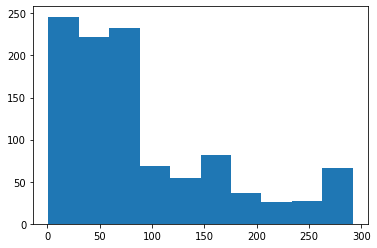

In [160]:
plt.hist(observed_eqdata["duration"]);

In [161]:
center_point = {'geometry': [ Point(37.855,-122.257 )]}
center = gpd.GeoDataFrame(d, crs="EPSG:4326")
center

ValueError: Assigning CRS to a GeoDataFrame without a geometry column is not supported. Supply geometry using the 'geometry=' keyword argument, or by providing a DataFrame with column name 'geometry'

In [ ]:
def convert_syn_data():
    latitudes = []
    longitudes = []
    names = []
    max_amp = []
    duration = []
    for file in os.listdir('sw4_test_output'): 
        if (len(file)<= 15 and file !='g1.dat'):
            st_syn = read('sw4_test_output'+'/'+file)
            longitudes.append(st_syn[0].stats["sac"]["stlo"])
            latitudes.append(st_syn[0].stats["sac"]["stla"])
            duration.append(duration_calc(st_syn[0].data, st_syn[0].times(), 90))
            names.append(file)
            max_amp.append(max(abs(st_syn[0].data)))
            
    data_dict = { 'name': names,'lon': longitudes, 'lat': latitudes, 'max_amp': max_amp, 'duration': duration}
    df = pd.DataFrame(data=data_dict)
    crs = 'EPSG:4326'
    geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
    geo_df = gpd.GeoDataFrame(df, 
                          crs = crs, 
                          geometry = geometry)
    
    return geo_df

In [ ]:
#fig, ax = plt.subplots(figsize=(15,15))
#test_geo.plot(ax= north_a.plot(ax=ax, edgecolor='k',alpha=1,linewidth=1,cmap="PiYG", aspect = 1), alpha = 0.5,color='blue')

In [ ]:
name = observed_eqdata.explore(column= 'duration', legend=True, vmax=150 )
geo_df.explore(m=name, color='red', marker_kwds = {"radius":7, "icon": "marker"})
#plt.scatter(x=-122.257, y=37.855, color="chartreuse", marker="*", s=500)

In [ ]:
synthetic_eqdata = convert_syn_data()
synthetic_eqdata

In [ ]:
plt.hist(synthetic_eqdata["duration"]);

The "durations" of synthetic earthquake following the method I used looks a lot more normal than the observed "durations" which look more skewed.

Potentially, next I could try to merge the data frames to make better comparisons of observed and synthetic data.

### comment:

the convert_data function can be altered so singular data points of choice can be added, and I suspect you could use this to change colors of the plot.  I have yet to explore if I can put entire arrays of the data points into the data frame to easily create a plot of any earthquake I wanr though. Also, a copy of convert_data can be made so it works on the synthetic data too, because currently I only implemented it to read from the observed data folder.

https://stackoverflow.com/questions/45548426/store-numpy-array-in-cells-of-a-pandas-dataframe

Need to do more experimentation on adding arrays of the data into the data frame.

https://geopandas.org/en/stable/docs/user_guide/mapping.html

Things to calculate: distance from point, angle from point, synthetic vs obs "duration", synthetic vs obs "max", 

In [ ]:
combined = synthetic_eqdata.merge(observed_eqdata, how = 'inner', on = 'name', suffixes = ["_syn", "_obs"])
combined = combined[["name", "lon_syn", "lat_syn", "max_amp_syn", "duration_syn", "geometry_syn", "max_amp_obs", "duration_obs"]]
combined

Only 875 readings have both synthetic and observed so I ommitted readings that were only in one table and not the other.

In [ ]:
sns.histplot(data = combined, x = "duration_syn", label = "synthetic", stat= "density");
sns.histplot(data = combined, x = "duration_obs", color = "orange", label = "observed",stat = "density");
plt.xlabel("Duration");
plt.title("Distributions of Synthetic and Observed Durations")
plt.legend();

In [ ]:
sns.histplot(data = combined, x = "max_amp_syn", label = "synthetic", stat= "density");
sns.histplot(data = combined, x = "max_amp_obs", color = "orange", label = "observed",stat = "density");
plt.xlabel("max_amp");
plt.legend();

The max_amp clearly has some outliers.

In [ ]:
plt.scatter(x = combined["duration_syn"], y = combined["duration_obs"]);
x = np.linspace(0,300,500)
y = x
plt.plot(x, y, label='y=x', color = "red");
plt.xlim(0, 100);
plt.xlabel("synthetic duration");
plt.ylabel("observed duration");

We saw this last time already but I recreated it I guess.

In [ ]:
from math import cos, asin, sqrt, pi

def distance_from_eq(lat2, lon2):
    p = np.pi/180
    a = 0.5 - np.cos((lat2-37.855)*p)/2 + np.cos(37.855*p) * np.cos(lat2*p) * (1-np.cos((lon2-(-122.257))*p))/2
    return 12742 * np.arcsin(np.sqrt(a))

Distance code found on the internet. https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula


In [ ]:
def classify_quadrant(lat, lon):
    n = (lat >= 37.855)
    if n:
        if lon >= -122.257:
            return 1
        else: 
            return 4
    else:
        if lon >= -122.257:
            return 2
        else:
            return 3

In [ ]:
#classify_quadrant(combined["lat_syn"], combined["lon_syn"])

In [ ]:

combined["distance_km"] = distance_from_eq(combined["lat_syn"], combined["lon_syn"])
combined

In [ ]:
plt.scatter(x = combined["duration_syn"], y = combined["duration_obs"], alpha = .8, c = combined["distance_km"], cmap = 'seismic')
cbar = plt.colorbar()
plt.plot(x, y, label='y=x', color = "green");
plt.xlim(0, 100);
plt.xlabel("synthetic duration");
plt.ylabel("observed duration");

Maybe more lower distances are under the line, but overall, distances above the line are both low and high.

In [ ]:
plt.scatter(x = np.log(combined["max_amp_syn"]), y = np.log(combined["max_amp_obs"]), alpha = .8, c = combined["distance_km"], cmap = 'seismic')
cbar = plt.colorbar()
x = np.linspace(-11,-2,500)
y = x
plt.plot(x, y, label='y=x', color = "green");

plt.xlabel("synthetic max amp");
plt.ylabel("observed max amp");

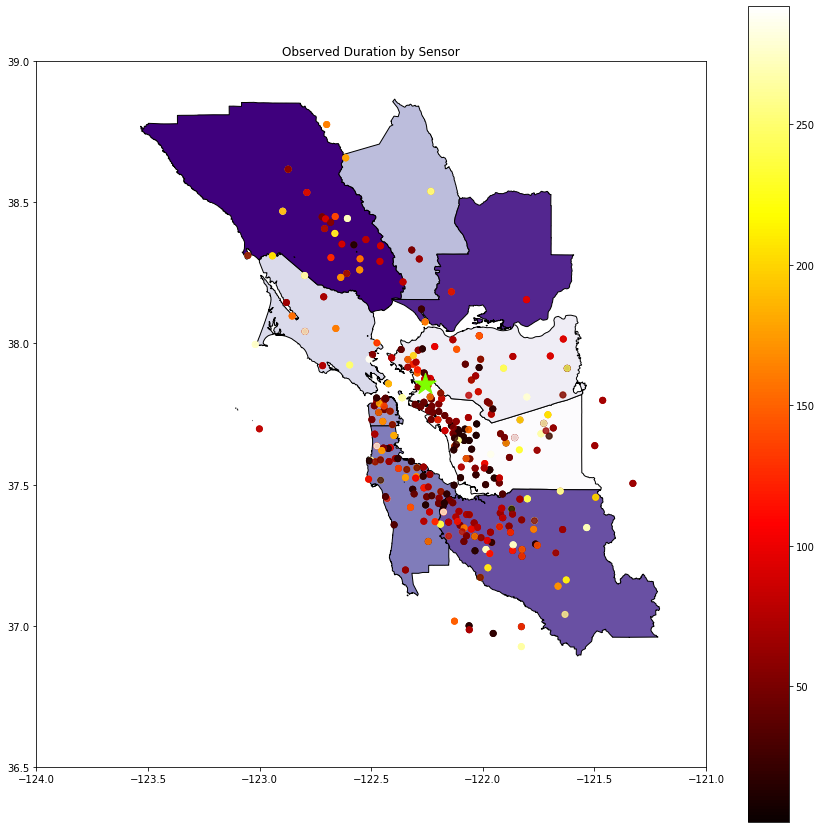

In [163]:
combined = gpd.GeoDataFrame(combined, geometry = "geometry_syn")
fig, ax = plt.subplots(figsize=(15,15))
bay_shapefile = gpd.read_file('bayarea_county.shp')
bay_shapefile.crs = "EPSG:3494"
bay_shapefile = bay_shapefile.to_crs("EPSG:4326")

bay_shapefile.plot(ax=ax, edgecolor='k',alpha=1,linewidth=1,cmap="Purples", aspect = 1)
combined.plot(ax= ax, alpha = 0.8, column ="duration_obs", cmap="hot", legend=True )
plt.xlim(-124, -121)
plt.ylim(36.5, 39)
plt.scatter(x=-122.257, y=37.855, color="chartreuse", marker="*", s=500)
plt.title("Observed Duration by Sensor");
plt.show();

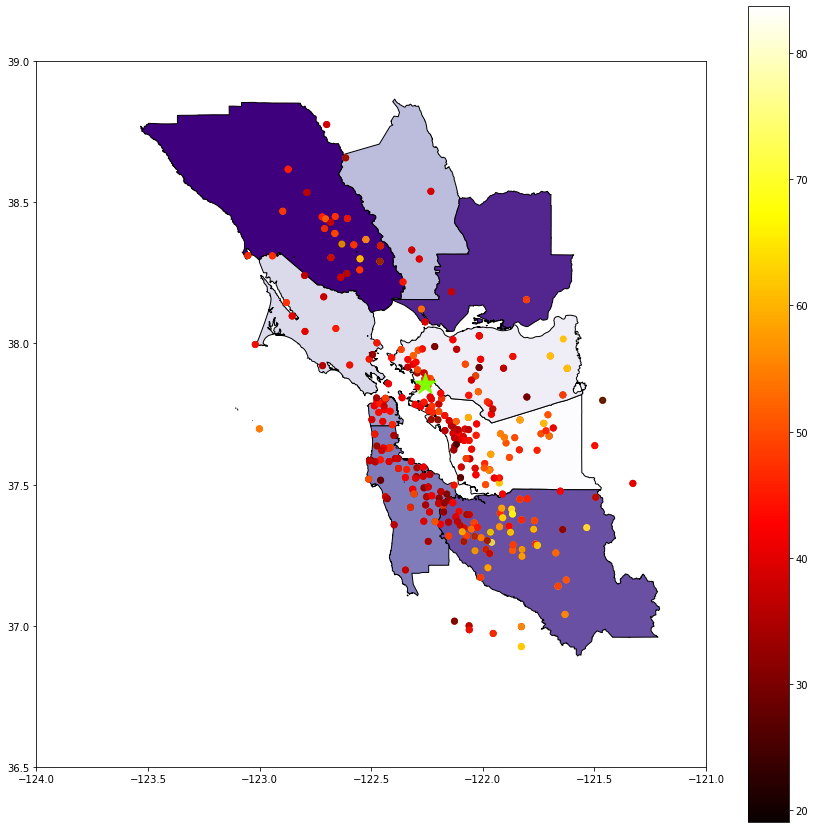

In [164]:
combined = gpd.GeoDataFrame(combined, geometry = "geometry_syn")
fig, ax = plt.subplots(figsize=(15,15))
bay_shapefile = gpd.read_file('bayarea_county.shp')
bay_shapefile.crs = "EPSG:3494"
bay_shapefile = bay_shapefile.to_crs("EPSG:4326")

bay_shapefile.plot(ax=ax, edgecolor='k',alpha=1,linewidth=1,cmap="Purples", aspect = 1)
combined.plot(ax= ax, alpha = 0.8, column ="duration_syn", cmap="hot", legend=True)
plt.scatter(x=-122.257, y=37.855, color="chartreuse", marker="*", s=500)
plt.xlim(-124, -121)
plt.ylim(36.5, 39)
plt.show();

In [165]:
def classify_quadrant(lat, lon):
    n1 = (lat >= 37.855).astype("int")
    n2 = (lon <= -122.257).astype("int")
    nums = 2*n2 + n1 + 1
    return nums.map({1:2, 2:1, 3:3, 4:4})

#1 and 2 were swapped so had to remap..


In [166]:
combined["quadrant"] = classify_quadrant(combined["lat_syn"], combined["lon_syn"])
combined

,name,lon_syn,lat_syn,max_amp_syn,duration_syn,geometry_syn,max_amp_obs,duration_obs,distance_km,quadrant
0,NC.C049.HN.e,-122.278458,37.776600,0.004714,39.788999,POINT (-122.27846 37.77660),0.012901,54.290,8.968740,3
1,NC.JSA.HN.u,-122.420059,37.582249,0.000103,39.788999,POINT (-122.42006 37.58225),0.003152,70.780,33.544395,3
2,NC.J004.HN.e,-122.036446,37.317459,0.000296,37.603619,POINT (-122.03645 37.31746),0.003191,76.290,62.830891,2
3,NC.J041.HN.n,-122.441444,37.800491,0.000685,42.727959,POINT (-122.44144 37.80049),0.015917,39.055,17.359102,3
4,NC.N002.HN.n,-122.140739,38.182613,0.000858,41.484553,POINT (-122.14074 38.18261),0.000755,83.580,37.827293,1
...,...,...,...,...,...,...,...,...,...,...
870,CE.58395.HN.u,-122.380997,37.592499,0.000219,37.905050,POINT (-122.38100 37.59250),0.001993,16.700,31.139484,3
871,NP.1778.HN.e,-121.979782,37.302494,0.000210,31.951772,POINT (-121.97978 37.30249),0.004043,96.000,66.104706,2
872,BK.MHC.HN.u,-121.642570,37.341640,0.000066,29.201207,POINT (-121.64257 37.34164),0.000994,66.220,78.661095,2
873,BK.MCCM.HN.u,-122.880180,38.144779,0.000134,47.400152,POINT (-122.88018 38.14478),0.000565,67.530,63.410622,4


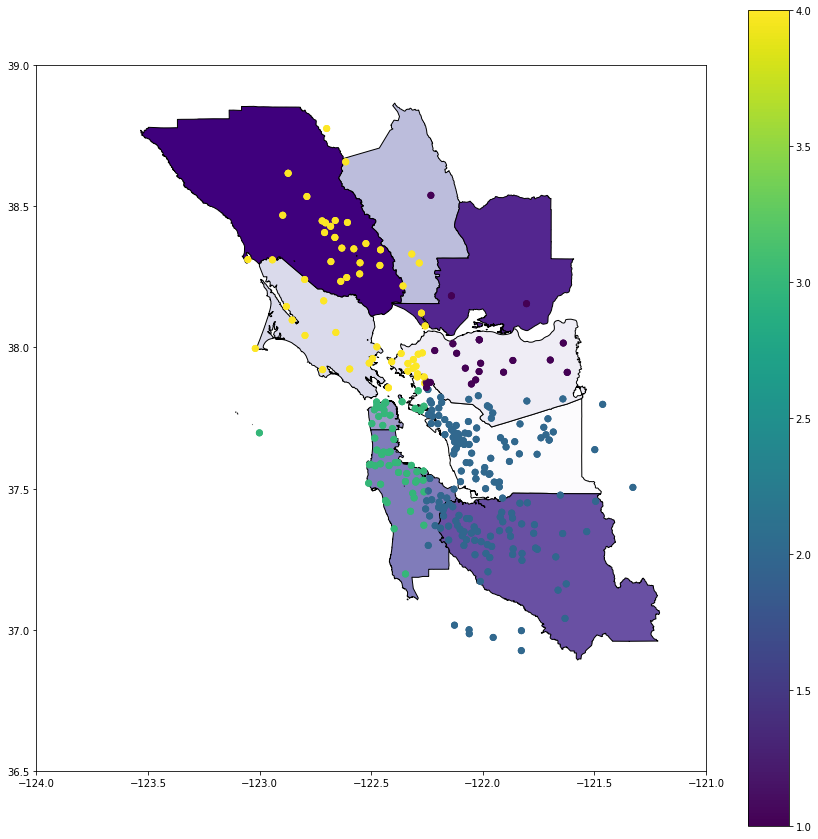

In [167]:
combined = gpd.GeoDataFrame(combined, geometry = "geometry_syn")
fig, ax = plt.subplots(figsize=(15,15))
bay_shapefile = gpd.read_file('bayarea_county.shp')
bay_shapefile.crs = "EPSG:3494"
bay_shapefile = bay_shapefile.to_crs("EPSG:4326")

bay_shapefile.plot(ax=ax, edgecolor='k',alpha=1,linewidth=1,cmap="Purples", aspect = 1)
combined.plot(ax= ax, alpha = 0.8, column ="quadrant", legend=True )
plt.xlim(-124, -121)
plt.ylim(36.5, 39)
plt.show();

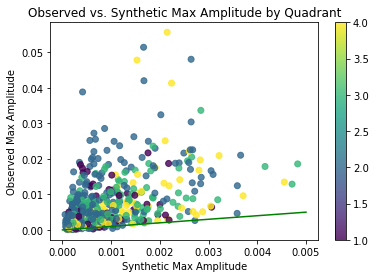

In [170]:
plt.scatter(x = (combined["max_amp_syn"]), y = (combined["max_amp_obs"]), alpha = .8, c = combined["quadrant"])
cbar = plt.colorbar()
x = np.linspace(0,0.005)
y = x
plt.plot(x, y, label='y=x', color = "green");

plt.xlabel("Synthetic Max Amplitude");
plt.ylabel("Observed Max Amplitude");
plt.title("Observed vs. Synthetic Max Amplitude by Quadrant");

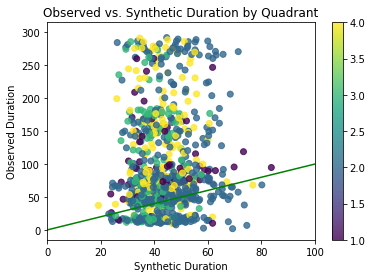

In [77]:
plt.scatter(x = combined["duration_syn"], y = combined["duration_obs"], alpha = .8, c = combined["quadrant"])
x = np.linspace(0,300,500)
y = x
cbar = plt.colorbar()
plt.plot(x, y, label='y=x', color = "green");
plt.xlim(0, 100);
plt.xlabel("Synthetic Duration");
plt.ylabel("Observed Duration");
plt.title("Observed vs. Synthetic Duration by Quadrant");

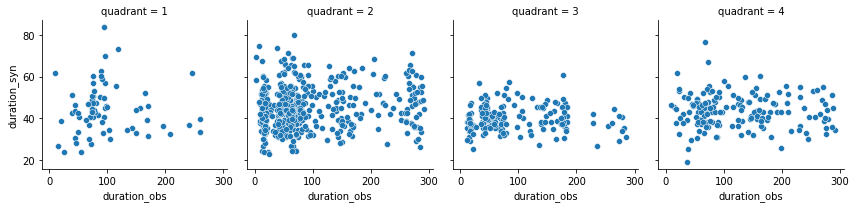

In [72]:
g = sns.FacetGrid(combined,  col="quadrant")
g.map(sns.scatterplot, "duration_obs", "duration_syn");
def const_line(*args, **kwargs):
    x = np.arange(0, 300, .5)
    y = x
    plt.plot(y, x, color = "green")

#g.map(const_line);


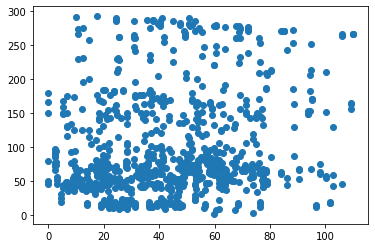

In [172]:
plt.scatter(combined["distance_km"], combined["duration_obs"]);

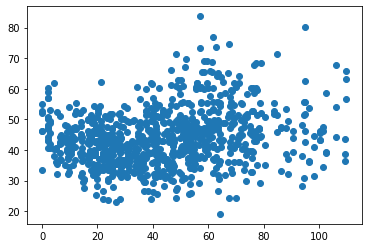

In [173]:
plt.scatter(combined["distance_km"], combined["duration_syn"]);